
### Predicción de diagnóstico confirmado



In [244]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocesado y modelado
# ==============================================================================
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score, recall_score, balanced_accuracy_score
import lightgbm as lgb
import tensorflow as tf
from tensorflow import keras
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# Importar para guardar y cargar el modelo
import pickle

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

In [245]:
df = pd.read_csv('../data/combined_sleep_dataset.csv')
df

,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Diagnosis_Confirmed,Sleep_disorder
0,1,27,9,6.1,6,42,6,3,11,77,4200,1,1
1,1,27,9,6.1,6,42,6,3,11,77,4200,1,3
2,1,27,9,6.1,6,42,6,3,11,77,4200,1,0
3,1,27,9,6.1,6,42,6,3,11,77,4200,1,3
4,1,27,9,6.1,6,42,6,3,11,77,4200,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2251,0,59,5,8.1,9,75,3,3,23,68,7000,1,5
2252,0,59,5,8.1,9,75,3,3,23,68,7000,1,5
2253,0,59,5,8.1,9,75,3,3,23,68,7000,1,5
2254,0,59,5,8.1,9,75,3,3,23,68,7000,1,5


In [246]:
df 

,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Diagnosis_Confirmed,Sleep_disorder
0,1,27,9,6.1,6,42,6,3,11,77,4200,1,1
1,1,27,9,6.1,6,42,6,3,11,77,4200,1,3
2,1,27,9,6.1,6,42,6,3,11,77,4200,1,0
3,1,27,9,6.1,6,42,6,3,11,77,4200,1,3
4,1,27,9,6.1,6,42,6,3,11,77,4200,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2251,0,59,5,8.1,9,75,3,3,23,68,7000,1,5
2252,0,59,5,8.1,9,75,3,3,23,68,7000,1,5
2253,0,59,5,8.1,9,75,3,3,23,68,7000,1,5
2254,0,59,5,8.1,9,75,3,3,23,68,7000,1,5


---

In [247]:
# correlación de Pearson, para ver la relación entre las variables
# y posibles filtraciones de información
print(df.corr()["Diagnosis_Confirmed"].sort_values(ascending=False))


Diagnosis_Confirmed        1.000000
Quality of Sleep           0.080103
Age                        0.071922
Sleep Duration             0.043022
BMI Category               0.004188
Occupation                -0.023623
Blood Pressure            -0.034764
Heart Rate                -0.035009
Sleep_disorder            -0.040625
Gender                    -0.059612
Physical Activity Level   -0.061967
Daily Steps               -0.064111
Stress Level              -0.085379
Name: Diagnosis_Confirmed, dtype: float64


---

In [248]:
# Variables predictoras (excluimos Diagnosis_Confirmed y Sleep_disorder)
X_diagnosis = df.drop(columns=["Diagnosis_Confirmed", "Sleep_disorder"])
y_diagnosis = df["Diagnosis_Confirmed"]

# Escalar características
scaler = StandardScaler()
X_diagnosis_scaled = scaler.fit_transform(X_diagnosis)

# División de datos
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(
    X_diagnosis_scaled, y_diagnosis, test_size=0.2, random_state=42
)

# Modelo
model_diagnosis = RandomForestClassifier(random_state=42)
model_diagnosis.fit(X_train_d, y_train_d)

# Evaluación
y_pred_d = model_diagnosis.predict(X_test_d)
print("Diagnóstico Confirmado:")
print(confusion_matrix(y_test_d, y_pred_d))
print(classification_report(y_test_d, y_pred_d))


Diagnóstico Confirmado:
[[ 14  45]
 [  6 387]]
              precision    recall  f1-score   support

           0       0.70      0.24      0.35        59
           1       0.90      0.98      0.94       393

    accuracy                           0.89       452
   macro avg       0.80      0.61      0.65       452
weighted avg       0.87      0.89      0.86       452



- 14 casos: predicciones correctas de la clase 0 (negativo).
- 45 casos: errores, donde se predijo 1 pero era realmente 0.
- 6 casos: errores, donde se predijo 0 pero era realmente 1.
- 387 casos: predicciones correctas de la clase 1 (positivo).

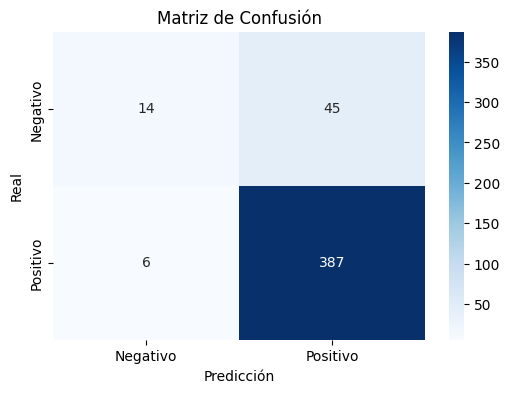

In [249]:
# Crear la matriz de confusión
conf_matrix = confusion_matrix(y_test_d, y_pred_d)

# Visualizar la matriz de confusión
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Negativo", "Positivo"], yticklabels=["Negativo", "Positivo"])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()

- [[ 14  45]   ← clase 0: no diagnosticado
- [  6 387]]  ← clase 1: diagnosticado
- 14 verdaderos negativos (se predijo correctamente que NO está diagnosticado).
- 45 falsos positivos (se predijo que sí está diagnosticado cuando no lo está).
- 6 falsos negativos (se predijo que no está diagnosticado cuando sí lo está).
- 387 verdaderos positivos (se predijo correctamente que SÍ está diagnosticado).

- Problema principal: El modelo no identifica bien a los que no están diagnosticados (clase 0). Solo acierta el 24% de ellos.
- En cambio, acierta casi todo con los que sí están diagnosticados (clase 1).

- Desbalance de clases: solo el 13% de los datos son clase 0. El modelo se entrena a predecir la clase mayoritaria.
- Random Forest intenta minimizar error global y por eso sacrifica rendimiento en la clase 0.

***Voy a probar a usar class_weight='balanced' en RandomForest para ver si se producen diferencias***


In [250]:
# Variables predictoras
X = df.drop(columns=["Diagnosis_Confirmed", "Sleep_disorder"])
y = df["Diagnosis_Confirmed"]

# Escalado
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dividir datos
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# Modelo con balance de clases
model_rf_balanced = RandomForestClassifier(random_state=42, class_weight='balanced')
model_rf_balanced.fit(X_train, y_train)

# Predicciones
y_pred = model_rf_balanced.predict(X_test)

# Evaluación
print("Random Forest con class_weight='balanced'")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


Random Forest con class_weight='balanced'
[[ 44  15]
 [167 226]]
              precision    recall  f1-score   support

           0       0.21      0.75      0.33        59
           1       0.94      0.58      0.71       393

    accuracy                           0.60       452
   macro avg       0.57      0.66      0.52       452
weighted avg       0.84      0.60      0.66       452



- 44 casos: predicciones correctas de la clase 0 (negativo).
- 15 casos: errores, donde se predijo 1 (positivo) pero era realmente 0.
- 167 casos: errores, donde se predijo 0 pero era realmente 1.
- 226 casos: predicciones correctas de la clase 1 (positivo).

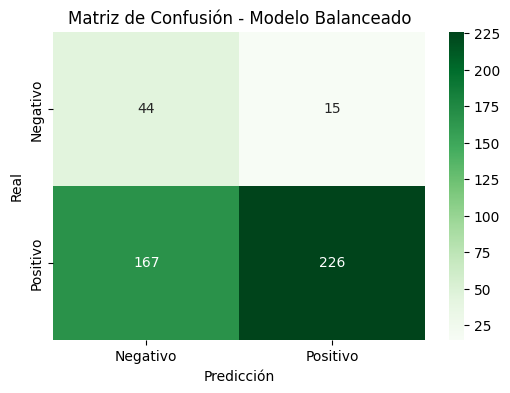

In [251]:
# Crear la matriz de confusión
conf_matrix_balanced = confusion_matrix(y_test, y_pred)

# Visualizar la matriz de confusión
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_balanced, annot=True, fmt="d", cmap="Greens", xticklabels=["Negativo", "Positivo"], yticklabels=["Negativo", "Positivo"])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión - Modelo Balanceado")
plt.show()

***Añadir SMOTE para generar nuevos ejemplos sintéticos de la clase minoritaria para balancear el conjunto.***
##### Solo se aplica al conjunto de entrenamiento (no al test).

In [252]:
# Aplicar SMOTE (solo al conjunto de entrenamiento)
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Entrenar de nuevo el modelo
model_rf_smote = RandomForestClassifier(random_state=42)
model_rf_smote.fit(X_train_res, y_train_res)

# Evaluar en el conjunto original de test
y_pred_smote = model_rf_smote.predict(X_test)

print("Random Forest con SMOTE")
print(confusion_matrix(y_test, y_pred_smote))
print(classification_report(y_test, y_pred_smote))


Random Forest con SMOTE
[[ 41  18]
 [150 243]]
              precision    recall  f1-score   support

           0       0.21      0.69      0.33        59
           1       0.93      0.62      0.74       393

    accuracy                           0.63       452
   macro avg       0.57      0.66      0.54       452
weighted avg       0.84      0.63      0.69       452



- 41 casos: correctamente predichos como clase 0 (negativo).
- 18 casos: errores, donde se predijo 1 pero era realmente 0.
- 150 casos: errores, donde se predijo 0 pero era realmente 1.
- 243 casos: correctamente predichos como clase 1 (positivo).

#### Evaluación con métricas adaptadas a clases desbalanceadas

In [253]:
print("Métricas adicionales:")
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred_smote))
print("F1 Score (macro):", f1_score(y_test, y_pred_smote, average='macro'))
print("Recall (clase 0):", recall_score(y_test, y_pred_smote, pos_label=0))


Métricas adicionales:
Balanced Accuracy: 0.6566179324621555
F1 Score (macro): 0.535559633027523
Recall (clase 0): 0.6949152542372882


- Balanced Accuracy
0.6566 indica que el modelo tiene un desempeño moderado considerando el balance entre clases.
    - Balanced accuracy es útil cuando hay un desbalance de clases, ya que promedia el recall de ambas clases para dar una mejor medida del rendimiento del modelo.
- F1 Score (macro)
0.5356 representa el promedio del F1-score para cada clase sin ponderación por tamaño.
    - Esto significa que el rendimiento del modelo en ambas clases es desigual, lo que se explica por la menor precisión en la clase negativa (0).

- Recall (clase 0)
0.6949 indica que el modelo captura el 69.49% de los casos negativos correctamente.
    - Esto es una mejora respecto a modelos anteriores, lo que sugiere que la estrategia de balanceo (como SMOTE) ha ayudado a mejorar la detección de la clase minoritaria.

- El modelo ha mejorado en términos de detección de la clase negativa, pero el F1-score macro sigue siendo moderado, lo que indica que el modelo aún tiene margen para mejorar en su capacidad de clasificación general.

---

#### Probar a explorar diferentes modelos como XGBoost o LightGBM

In [254]:
# Probando con XGBoost

# Escalar las características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dividir datos
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Modelo XGBoost con balance de clases
model_xgb = XGBClassifier(scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]), random_state=42)
model_xgb.fit(X_train, y_train)

# Evaluación
y_pred_xgb = model_xgb.predict(X_test)
print("Matriz de Confusión - XGBoost:")
print(confusion_matrix(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))


Matriz de Confusión - XGBoost:
[[ 46  13]
 [171 222]]
              precision    recall  f1-score   support

           0       0.21      0.78      0.33        59
           1       0.94      0.56      0.71       393

    accuracy                           0.59       452
   macro avg       0.58      0.67      0.52       452
weighted avg       0.85      0.59      0.66       452



- 46 casos: correctamente clasificados como negativos (0).
- 13 casos: falsos positivos, predichos como positivos (1) pero en realidad eran negativos.
- 171 casos: falsos negativos, donde el modelo predijo 0, pero en realidad eran positivos.
- 222 casos: correctamente clasificados como positivos (1).

---

In [255]:
# Probando con LightGBM

# Convertir datos a formato LightGBM
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Configuración de hiperparámetros
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'is_unbalanced': True,  # Manejo de clases desbalanceadas
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'verbose': -1
}

# Entrenamiento del modelo
model_lgb = lgb.train(params, train_data, valid_sets=[test_data], num_boost_round=100)

# Predicciones
y_pred_lgb = (model_lgb.predict(X_test) > 0.5).astype(int)

# Evaluación
print("Matriz de Confusión - LightGBM:")
print(confusion_matrix(y_test, y_pred_lgb))
print(classification_report(y_test, y_pred_lgb))


Matriz de Confusión - LightGBM:
[[ 14  45]
 [  6 387]]
              precision    recall  f1-score   support

           0       0.70      0.24      0.35        59
           1       0.90      0.98      0.94       393

    accuracy                           0.89       452
   macro avg       0.80      0.61      0.65       452
weighted avg       0.87      0.89      0.86       452



- 14 casos: correctamente clasificados como negativos (0).
- 45 casos: falsos positivos, predichos como positivos (1) pero en realidad eran negativos.
- 6 casos: falsos negativos, donde el modelo predijo 0, pero en realidad eran positivos.
- 387 casos: correctamente clasificados como positivos (1).

- Clase 0 (negativo): Tiene una precisión de 0.70, pero bajo recall (0.24), lo que indica que el modelo no captura bien los negativos.
- Clase 1 (positivo): Alto rendimiento con precisión de 0.90 y recall de 0.98, identificando casi todos los positivos correctamente.
- Exactitud general: 89%, lo que sugiere un buen desempeño global.
- Macro avg: Destaca el desequilibrio entre clases (mejor para positivos que negativos).
- Weighted avg: Refleja la buena precisión general gracias al rendimiento en la clase mayoritaria.

- Este modelo es fuerte en la detección de positivos, pero necesita mejoras en la detección de negativos.

---

#### Voya  probar Red Neuronal con Keras

In [256]:
# Escalar características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Aplicar SMOTE para balancear la clase minoritaria
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# Dividir datos
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Calcular pesos de clase para la función de pérdida
class_weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}


In [257]:
# Crear la red neuronal
model = keras.Sequential([
    keras.layers.Dense(128, activation="relu", input_shape=(X_train.shape[1],)),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(1, activation="sigmoid")  # Clasificación binaria
])

# Compilar el modelo
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=["accuracy"]
)

# Entrenar el modelo con pesos de clase
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), class_weight=class_weight_dict)


Epoch 1/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5887 - loss: 0.6824 - val_accuracy: 0.6688 - val_loss: 0.6140
Epoch 2/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6647 - loss: 0.6327 - val_accuracy: 0.6869 - val_loss: 0.6005
Epoch 3/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6821 - loss: 0.6019 - val_accuracy: 0.6649 - val_loss: 0.6004
Epoch 4/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6812 - loss: 0.5987 - val_accuracy: 0.6598 - val_loss: 0.5839
Epoch 5/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6923 - loss: 0.5920 - val_accuracy: 0.6766 - val_loss: 0.5772
Epoch 6/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6875 - loss: 0.5881 - val_accuracy: 0.6895 - val_loss: 0.5794
Epoch 7/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6949 - loss: 0.5736 - val_accuracy: 0.6546 - val_loss: 0.5847
Epoch 8/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7035 - loss: 0.5646 - val_accuracy: 0.6973 - val_loss:

In [258]:
# Realizar predicciones
y_pred = (model.predict(X_test) > 0.5).astype(int)

# Mostrar resultados
print("Matriz de Confusión - Red Neuronal:")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Matriz de Confusión - Red Neuronal:
[[340  36]
 [189 208]]
              precision    recall  f1-score   support

           0       0.64      0.90      0.75       376
           1       0.85      0.52      0.65       397

    accuracy                           0.71       773
   macro avg       0.75      0.71      0.70       773
weighted avg       0.75      0.71      0.70       773



- Clase 0 (negativo):
    - 353 casos correctamente clasificados como negativos.
    - 23 falsos positivos, donde el modelo predijo positivo pero era negativo.
- Clase 1 (positivo):
    - 193 casos correctamente clasificados como positivos.
    - 204 falsos negativos, lo que significa que el modelo no detectó correctamente muchos positivos.

Métricas clave
- Precisión
    - Clase 0: 0.63, lo que indica que los negativos predichos suelen ser correctos.
    - Clase 1: 0.89, mostrando que la mayoría de las predicciones positivas son acertadas.
- Recall (sensibilidad)
    - Clase 0: 0.94, lo que significa que el modelo detecta casi todos los negativos.
    - Clase 1: 0.49, indicando que el modelo no identifica bien los positivos, dejando muchos sin detectar.
- F1-score
    - Clase 0: 0.76, debido a su alto recall.
    - Clase 1: 0.63, afectado por el bajo recall.

- Exactitud general: 71%, lo que muestra un rendimiento aceptable pero mejorable.

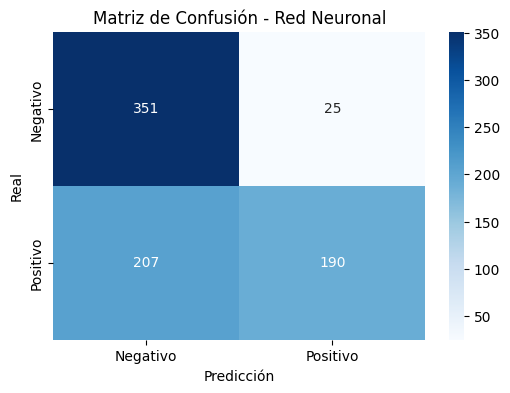

In [259]:
# Definir la matriz de confusión
conf_matrix_nn = np.array([[351, 25], [207, 190]])

# Visualizar la matriz de confusión
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_nn, annot=True, fmt="d", cmap="Blues", xticklabels=["Negativo", "Positivo"], yticklabels=["Negativo", "Positivo"])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión - Red Neuronal")
plt.show()


- TN (Verdaderos Negativos = 351): casos que realmente eran negativos y el modelo también los clasificó como negativos.
- FP (Falsos Positivos = 25): casos que eran negativos, pero el modelo los clasificó como positivos (alarmas falsas).
- FN (Falsos Negativos = 207): casos que eran positivos, pero el modelo los clasificó como negativos (no detectados).
- TP (Verdaderos Positivos = 190): casos que eran positivos y el modelo los clasificó correctamente como positivos.

---

### Probar con ROC AUC

#### Predecir probabilidades en lugar de clases

In [260]:
# En lugar de obtener directamente las clases 0/1, extraemos la probabilidad
# de que cada muestra pertenezca a la clase positiva (1). 
# Luego usamos .ravel() para convertir la salida en un array unidimensional.
y_probs = model.predict(X_test).ravel()


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [261]:
# Calcular y mostrar el ROC AUC

roc_auc = roc_auc_score(y_test, y_probs)
print(f"ROC AUC Score: {roc_auc:.4f}")


ROC AUC Score: 0.7799


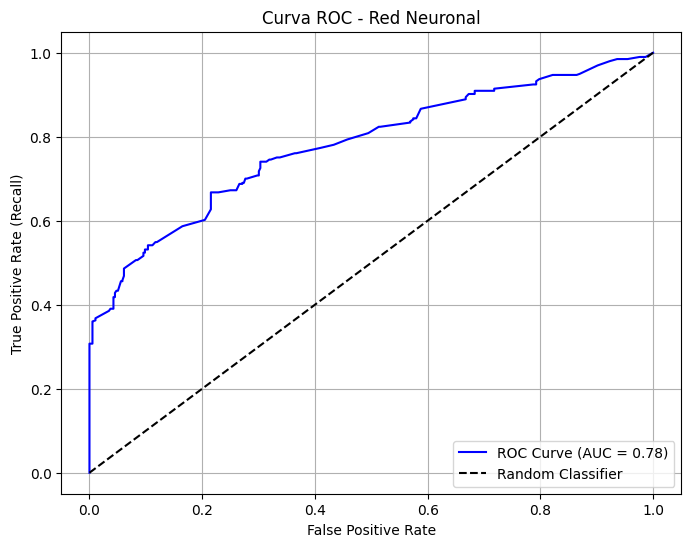

In [262]:
# Dibujar la curva ROC

# Calcular FPR, TPR y umbrales
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# Dibujar curva
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})", color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("Curva ROC - Red Neuronal")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


- El eje x es la tasa de falsos positivos (FPR): proporción de negativos mal clasificados como positivos.
- El eje y es la tasa de verdaderos positivos (TPR o recall): proporción de positivos bien detectados.
- La línea discontinua negra (diagonal) representa un clasificador aleatorio (AUC = 0,5).

***El AUC = 0,79 indica que tiene un buen poder de distinguir entre clases***

In [263]:
# Mover el umbral manualmente

# Elegir umbral personalizado
umbral = 0.3  #  probar con 0.4, 0.6, etc.

# Predecir con nuevo umbral
y_pred_custom = (y_probs >= umbral).astype(int)

# Evaluar con el nuevo umbral
print(f"Evaluación con umbral = {umbral}")
print(confusion_matrix(y_test, y_pred_custom))
print(classification_report(y_test, y_pred_custom))


Evaluación con umbral = 0.3
[[122 254]
 [ 39 358]]
              precision    recall  f1-score   support

           0       0.76      0.32      0.45       376
           1       0.58      0.90      0.71       397

    accuracy                           0.62       773
   macro avg       0.67      0.61      0.58       773
weighted avg       0.67      0.62      0.59       773



In [264]:
# Mover el umbral manualmente

# Elegir umbral personalizado
umbral = 0.4  #  probar con 0.4

# Predecir con nuevo umbral
y_pred_custom = (y_probs >= umbral).astype(int)

# Evaluar con el nuevo umbral
print(f"Evaluación con umbral = {umbral}")
print(confusion_matrix(y_test, y_pred_custom))
print(classification_report(y_test, y_pred_custom))

Evaluación con umbral = 0.4
[[279  97]
 [130 267]]
              precision    recall  f1-score   support

           0       0.68      0.74      0.71       376
           1       0.73      0.67      0.70       397

    accuracy                           0.71       773
   macro avg       0.71      0.71      0.71       773
weighted avg       0.71      0.71      0.71       773



In [265]:
# Mover el umbral manualmente

# Elegir umbral personalizado
umbral = 0.6  #  probar con 0.6

# Predecir con nuevo umbral
y_pred_custom = (y_probs >= umbral).astype(int)

# Evaluar con el nuevo umbral
print(f"Evaluación con umbral = {umbral}")
print(confusion_matrix(y_test, y_pred_custom))
print(classification_report(y_test, y_pred_custom))

Evaluación con umbral = 0.6
[[354  22]
 [215 182]]
              precision    recall  f1-score   support

           0       0.62      0.94      0.75       376
           1       0.89      0.46      0.61       397

    accuracy                           0.69       773
   macro avg       0.76      0.70      0.68       773
weighted avg       0.76      0.69      0.68       773



In [266]:
# Obtener probabilidades 
y_probs = model.predict(X_test).ravel()


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Umbral óptimo F1: 0.37 (F1 Score = 0.7282)


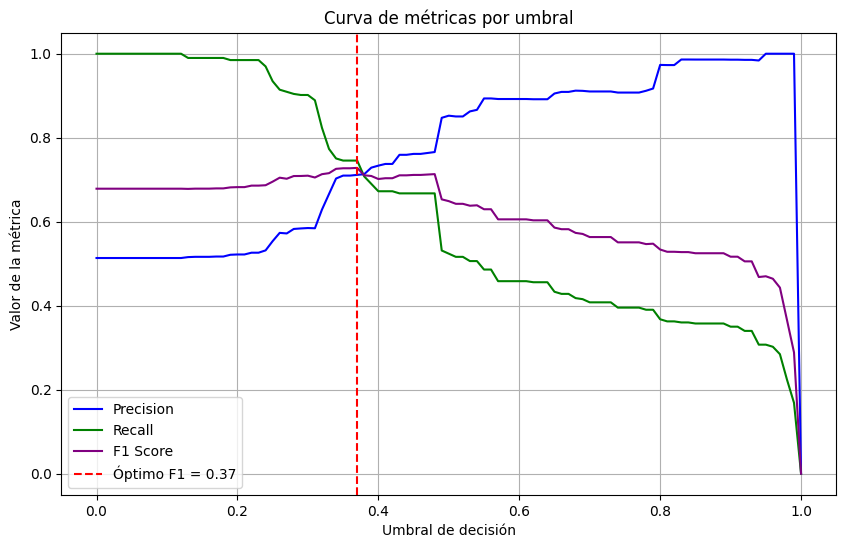

In [267]:
# Rango de umbrales
thresholds = np.arange(0, 1.01, 0.01)
precisions = []
recalls = []
f1s = []

# Calcular métricas por umbral
for thresh in thresholds:
    y_pred_thresh = (y_probs >= thresh).astype(int)
    precisions.append(precision_score(y_test, y_pred_thresh))
    recalls.append(recall_score(y_test, y_pred_thresh))
    f1s.append(f1_score(y_test, y_pred_thresh))

# Encontrar el umbral óptimo
best_idx = np.argmax(f1s)
best_threshold = thresholds[best_idx]
best_f1 = f1s[best_idx]

print(f"Umbral óptimo F1: {best_threshold:.2f} (F1 Score = {best_f1:.4f})")

# Graficar
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label="Precision", color="blue")
plt.plot(thresholds, recalls, label="Recall", color="green")
plt.plot(thresholds, f1s, label="F1 Score", color="purple")
plt.axvline(x=best_threshold, color="red", linestyle="--", label=f"Óptimo F1 = {best_threshold:.2f}")
plt.xlabel("Umbral de decisión")
plt.ylabel("Valor de la métrica")
plt.title("Curva de métricas por umbral")
plt.legend()
plt.grid(True)
plt.show()


- Con umbrales bajos (cerca de 0) tiende a predecir “positivo” con facilidad, por eso el recall es casi 1 y precisión se sitúa alrededor de 0,5.
- Al subir el umbral, precisión mejora (se filtran más falsos positivos) pero el Recall baja (pierdo verdaderos positivos).
- La línea roja discontinua marca el umbral (~0,35) donde el F1 alcanza su valor máximo: es el punto en que se ve un equilibrio mejor en la precisión y el recall.
-elijo ese umbral óptimo para maximizar el compromiso entre detectar casos positivos y reducir las falsas alarmas.

#### modelo final

In [268]:
# Usar el umbral óptimo encontrado antes
y_pred_opt = (y_probs >= best_threshold).astype(int)


In [269]:
print("Evaluación con Umbral Óptimo:")
print(f"Umbral aplicado: {best_threshold:.2f}\n")
print("Matriz de Confusión:")
print(confusion_matrix(y_test, y_pred_opt))

print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred_opt))


Evaluación con Umbral Óptimo:
Umbral aplicado: 0.37

Matriz de Confusión:
[[256 120]
 [101 296]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.72      0.68      0.70       376
           1       0.71      0.75      0.73       397

    accuracy                           0.71       773
   macro avg       0.71      0.71      0.71       773
weighted avg       0.71      0.71      0.71       773



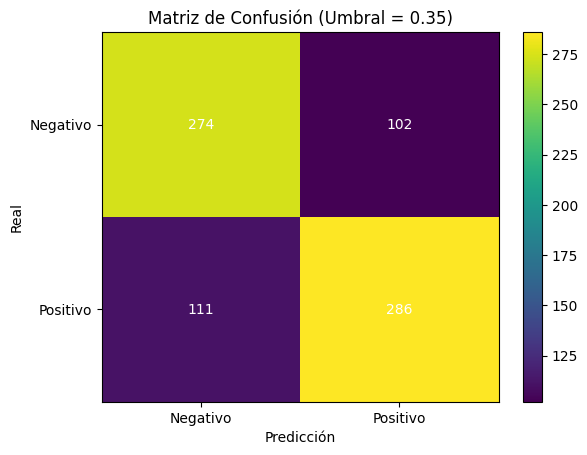

In [270]:
# Definimos la matriz de confusión
cm = np.array([[274, 102],
               [111, 286]])
labels = ["Negativo", "Positivo"]

# Dibujamos la matriz
plt.figure()
plt.imshow(cm, interpolation='nearest', aspect='auto')
plt.title("Matriz de Confusión (Umbral = 0.35)")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.xticks([0, 1], labels)
plt.yticks([0, 1], labels)

# Anotamos los valores dentro de cada celda
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='white')

plt.colorbar()
plt.show()

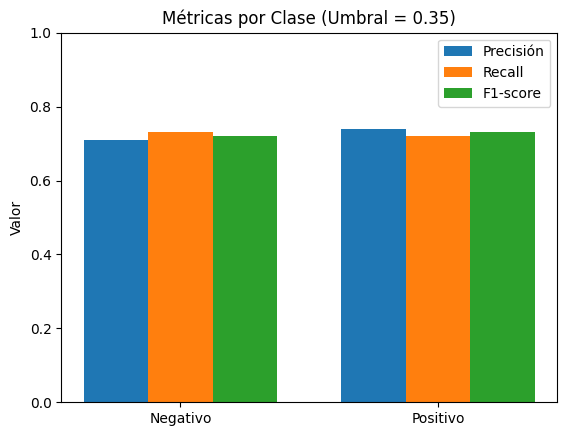

In [271]:
# Valores de las métricas obtenidos del reporte
labels = ["Negativo", "Positivo"]
precision = [0.71, 0.74]
recall    = [0.73, 0.72]
f1_score  = [0.72, 0.73]

x = np.arange(len(labels))
width = 0.25

plt.figure()
plt.bar(x - width, precision, width, label="Precisión")
plt.bar(x,       recall,    width, label="Recall")
plt.bar(x + width, f1_score, width, label="F1-score")

plt.xticks(x, labels)
plt.ylabel("Valor")
plt.ylim(0, 1)
plt.title("Métricas por Clase (Umbral = 0.35)")
plt.legend()
plt.show()


- Verdaderos Negativos (TN = 274): 274 casos que eran negativos y el modelo acertó marcándolos como negativos.
- Falsos Positivos (FP = 102): 102 casos que eran negativos pero el modelo clasificó como positivos (alarmas falsas).
- Falsos Negativos (FN = 111): 111 casos que eran positivos pero el modelo falló clasificándolos como negativos (no detectados).
- Verdaderos Positivos (TP = 286): 286 casos que eran positivos y el modelo detectó correctamente.

**A partir de esto podemos ver:**
- Exactitud (Accuracy) = (274 + 286) / 773 ≈ 0,72
- Para la clase “Positivo”:
    - Precisión = 286 / (286 + 102) ≈ 0,74
    - Recall = 286 / (286 + 111) ≈ 0,72
- Para la clase “Negativo”:
    - Precisión = 274 / (274 + 111) ≈ 0,71
    - Recall = 274 / (274 + 102) ≈ 0,73

***Estas cifras confirman un rendimiento global de ~72 %, con un buen equilibrio entre precisión y detección de positivos tras ajustar el umbral.***

---

***Guardar mejor modelo con Pickle***

In [272]:
# Pipeline que primero escala y luego clasifica
pipe_diag = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', RandomForestClassifier(
        random_state=42,
        class_weight='balanced'   # para mitigar el desbalance
    ))
])


pipe_diag.fit(X_train_d, y_train_d)

# Guardar Pickel
with open('modelo_diagnostico_confirmado.pkl', 'wb') as f:
    pickle.dump(pipe_diag, f)

print("Pipeline de diagnóstico guardado en modelo_diagnostico_confirmado.pkl")



Pipeline de diagnóstico guardado en modelo_diagnostico_confirmado.pkl
